## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.user_id.count()

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('(landing_page == "new_page" & group == "control") | (landing_page == "old_page" & group == "treatment")').count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**No row has missing value**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('(landing_page == "new_page" & group == "treatment") | (landing_page == "old_page" & group == "control")')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset ="user_id", inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# Same as old page group
control_df = df2[df2['group'] == 'control']
print("Control group: " + str(control_df.converted.mean()))

Control group: 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_df = df2[df2['group'] == 'treatment']
print("Treatment group: " + str(treatment_df.converted.mean()))

Treatment group: 0.11880806551510564


d. What is the probability that an individual received the new page?

In [17]:
df2[df2['landing_page'] == 'new_page'].count()[0]/df2.count()[2]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**In my opinion, there is not sufficient evidence to conclude that the new treatment page leads more conversion based on the probability provided which is 0.1188 lower that old page which is 0.1204.**


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$: $p_{old}$ >= $p_{new}$**

**$H_{1}$: $p_{old}$ < $p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2[df2['landing_page'] == 'new_page'].count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2[df2['landing_page'] == 'old_page'].count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(n_new,p_new)/n_new

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(n_old,p_old)/n_old

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
p_news = np.random.binomial(n_new,treatment_df.converted.mean(),10000)/n_new
p_olds = np.random.binomial(n_old,control_df.converted.mean(),10000)/n_old
p_diffs = p_news - p_olds
p_diffs

array([-0.00130986, -0.00376005, -0.00323005, ..., -0.00266575,
       -0.00043581, -0.00277592])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  19.,  155.,  611., 1528., 2624., 2575., 1583.,  713.,  167.,
          25.]),
 array([-5.81138503e-03, -4.97579269e-03, -4.14020034e-03, -3.30460800e-03,
        -2.46901565e-03, -1.63342330e-03, -7.97830959e-04,  3.77613868e-05,
         8.73353732e-04,  1.70894608e-03,  2.54453842e-03]),
 <a list of 10 Patch objects>)

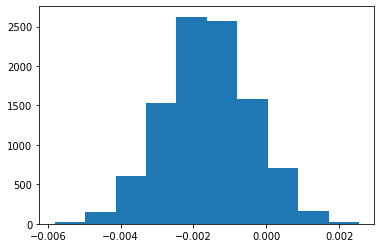

In [26]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

(array([6.000e+00, 7.500e+01, 4.250e+02, 1.628e+03, 3.007e+03, 2.920e+03,
        1.497e+03, 3.840e+02, 5.700e+01, 1.000e+00]),
 array([-4.95633472e-03, -3.95961254e-03, -2.96289035e-03, -1.96616816e-03,
        -9.69445975e-04,  2.72762129e-05,  1.02399840e-03,  2.02072059e-03,
         3.01744278e-03,  4.01416496e-03,  5.01088715e-03]),
 <a list of 10 Patch objects>)

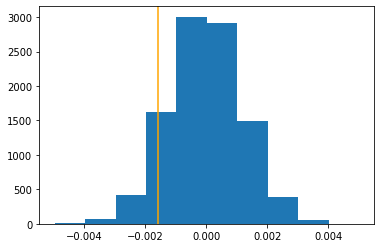

In [27]:
obs_diff = treatment_df.converted.mean() - control_df.converted.mean()
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.shape[0])
plt.axvline(x=obs_diff, color='orange')
plt.hist(null_vals)

In [28]:
(null_vals > obs_diff).mean()

0.9029

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Based on the p-value calculated in j, we have no enough evidence to reject the null hypothesis with the alpha of 0.05.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page'] == 'old_page')].converted.sum()
convert_new = df2[(df2['landing_page'] == 'new_page')].converted.sum()
n_old = df2[(df2['landing_page'] == 'old_page')].count()[0]
n_new = df2[(df2['landing_page'] == 'new_page')].count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
stat, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(stat)
print(pval)

1.3109241984234394
0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score = 1.311, p-value = 0.905, this mean that assuming the null hypothesis is true, there is 90.5% of chance to getting the sample result. Yes, both of the methods produced almost similar result**

#### Part II Conclusion

According to the result of hypothesis testing, we have no enough evidence to reject the null hypothesis with the alpha of 0.05. Thus, launching the new landing page is not recommended.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
dummy = pd.DataFrame()
dummy[['treatment', 'control']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = dummy['treatment']
df2['intercept'] = 1
df2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 09 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        12:13:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
np.exp(-0.0150)

0.9851119396030626

**Conversion is 0.985 time likely on treatment group than control group holding all else constant**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**Part II is using one-tailed which is P < z, which calculate the area of graph at the left side of z-score, meanwhile Part III using two-tailed test to compute the p-value which P > |z| that calulate the area of both side (area on right of z and left of -z) to find out the p-value**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It could be whether the user have previous purchase history. This might help to increase the confidence of the analysis, but it also might affect the overall performance of the model**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
df_countries = pd.read_csv('countries.csv')
df_countries.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [35]:
df_countries[['CA', 'UK', 'US']] = pd.get_dummies(df_countries['country'])
df_countries.head(3)

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0


In [36]:
df3 = df2.join(df_countries.set_index('user_id'), on='user_id')

In [37]:
df3['UK_new_page'] = df3['UK'] * df3['ab_page']
df3['US_new_page'] = df3['US'] * df3['ab_page']
df3['CA_new_page'] = df3['CA'] * df3['ab_page']

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']]).fit()
lm.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 09 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        12:23:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [43]:
np.exp(lm.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

**The conversion is 0.96 likely on the CA user compare to US user and conversion is 1.01 likely on UK user compare to US user. Since there was no variable is smaller that 0.05, we have no evidence to reject the null hypothetsis**

In [38]:
lm2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'CA_new_page', 'UK_new_page']]).fit()
lm2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 09 Apr 2020   Pseudo R-squ.:               3.482e-05
Time:                        12:13:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page        -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA             -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK             -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_new_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_new_page     0.0314      0.027      1.181      0.238      -0.021       0.084
===============================================================================
"""

In [39]:
np.exp(lm2.params)

intercept      0.137178
ab_page        0.979646
CA             0.982625
UK             0.994272
CA_new_page    0.954198
UK_new_page    1.031896
dtype: float64

**Based on the result, we can say that the conversion is 0.983 likely on the CA user compare to US user. Conversion is 0.994 likely on UK user compare to US user. Meanwhile, the conversion is 0.954 likely occurs on the new landing page among CA user compare to US user and the conversion is 1.032 likely occurs on the new landing page among UK user compare to US user. Since there were no variable with p-value smaller than 0.05, we have no evidence to reject that the old landing page is better. Thus, updating the landing page is not recommended**

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0